# Using regionprops_3d to analyze properties of each pore
The ``regionprops`` function included in *Scikit-image* is pretty thorough, and the recent version of *Scikit-image* (>0.14) vastly increase support for 3D images.  Nonetheless, there are still a handful of features and properties that are useful for porous media analysis.  The ``regionprops_3d`` in *PoreSpy* aims to address thsi need, and it's use is illustrated here.

In [1]:
import numpy as np
import porespy as ps
import scipy.ndimage as spim
import matplotlib.pyplot as plt
ps.visualization.set_mpl_style()
np.random.seed(1)

## Generating a test image
Start by generating a test image using the ``generators`` module in *PoreSpy*.

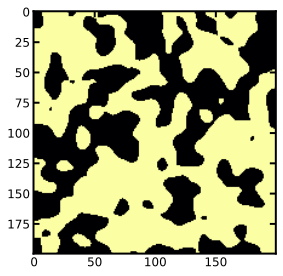

In [2]:
im = ps.generators.blobs(shape=[200, 200], porosity=0.6, blobiness=1)
fig, ax = plt.subplots()
ax.imshow(im, cmap=plt.cm.inferno);

## Segementing void space into regions for individual analysis
Next, we need to segment the image into discrete pores, which will become the *regions* that we analyze.  For this purpose we'll use the SNOW algorithm, which helps to find true local maximums in the distance transform that are used as markers in the *watershed* segementation.

In [3]:
snow = ps.filters.snow_partitioning(im=im)
regions = snow.regions*snow.im

0it [00:00, ?it/s]

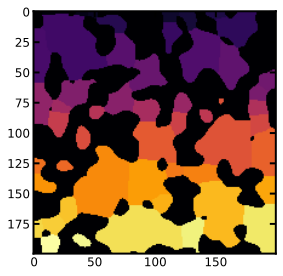

In [4]:
fig, ax = plt.subplots()
ax.imshow(regions, cmap=plt.cm.inferno);

## Applying regionsprops_3d
Now that the void space has been segmented into discrete regions, it's possible to extract information about each region using ``regionsprops_3d``.  

> **NOTE**: *PoreSpy* calls the *Scikit-image* ``regionprops`` function internally, and uses many of it's values in subsequent calculations.  The result return by ``regionprops_3d`` is the same as ``regionprops`` of *Scikit-image*, but with additional information added to each region.

In [5]:
props = ps.metrics.regionprops_3D(regions)

> **NOTE:** The ``regionprops_3d`` function in *PoreSpy* is compatible with the ``regionsprops`` function in *Scikit-image*, which returns the results in a somewhat confusing format.  An object is created for each region, and the properites of that region can be accessed as attributes of the object (e.g. ``obj[10].area``).  This makes it somewhat annoying, since all the ``area`` values cannot be accessed as a single array (*PoreSpy* has a function to address this, described below), but there is another larger *gotcha*:  Each of the region objects are collected in a list like ``[obj1, obj2, ...]``, **BUT** all regions labelled with 0 are ignored (which is solid phase in this example), so the object located in position 0 of the list corresponds to region 1.  Hence, users must be careful to index into the list correctly.

## Listing all available properties
Let's look at some of the properties for the regions, starting by printing a list of all available properties for a given region:

In [6]:
r = props[3]
attrs = [a for a in r.__dir__() if not a.startswith('_')]
print(attrs)

['label', 'slice', 'mask', 'slices', 'volume', 'bbox_volume', 'border', 'dt', 'inscribed_sphere', 'sphericity', 'skeleton', 'surface_area', 'surface_mesh_vertices', 'surface_mesh_simplices', 'convex_volume', 'area', 'bbox', 'area_bbox', 'centroid', 'area_convex', 'image_convex', 'coords', 'eccentricity', 'equivalent_diameter_area', 'euler_number', 'extent', 'feret_diameter_max', 'area_filled', 'image_filled', 'image', 'inertia_tensor', 'inertia_tensor_eigvals', 'image_intensity', 'centroid_local', 'intensity_max', 'intensity_mean', 'intensity_min', 'axis_major_length', 'axis_minor_length', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'orientation', 'perimeter', 'perimeter_crofton', 'solidity', 'centroid_weighted', 'centroid_weighted_local', 'moments_weighted', 'moments_weighted_central', 'moments_weighted_hu', 'moments_weighted_normalized']


## Analyze properties for a single region
Now let's look at some of the properties for each region, first view image of the region in isolation

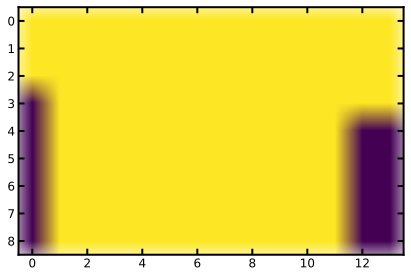

In [7]:
fig, ax = plt.subplots()
ax.imshow(r.image);

View image of region's border and largest incribed sphere together.

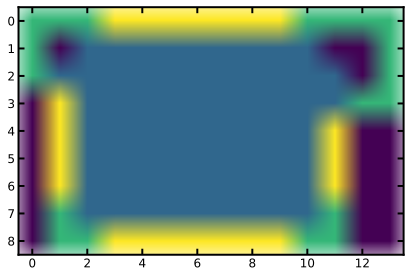

In [8]:
fig, ax = plt.subplots()
ax.imshow(r.border + 0.5*r.inscribed_sphere);

One of the more interesting properties is the convex image, which is an image of the region with all the depressions in the boundary filled in.  This is useful because one can compare it to the actual region and learn about the shape of the region.  One such metric is the *solidity* which is defined as the ratio of pixels in the region to pixels of the convex hull image.

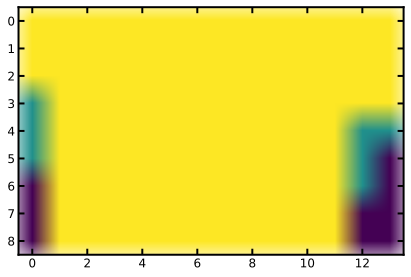

In [9]:
fig, ax = plt.subplots()
ax.imshow(r.image + 1.0*r.convex_image);

In [10]:
print(f"Solidity: {r.solidity:.3f}")

Solidity: 0.940


## Extracting one property for all regions as an array

As mentioned above, the *list* of objects that are returned by the ``regionprops_3d`` funciton is a bit inconvenient for accessing one piece of information for all regions at once.  *PoreSpy* has a function called ``props_to_DataFrame`` which helps in this regard by generating a Pandas DataFrame object with all of the *key metrics* listed as Numpy arrays in each column.  *Key metrics* refers to scalar values like area and solidity.

In [11]:
df = ps.metrics.props_to_DataFrame(props)

As can be seen above, there are fewer items in this DataFrame than on the regionprops objects.  This is because only scalar values are kept (e.g. images are ignored), and some of the metrics were not valid (e.g. intensity_image).

With this DataFrame in hand, we can now look a histograms of various properties:

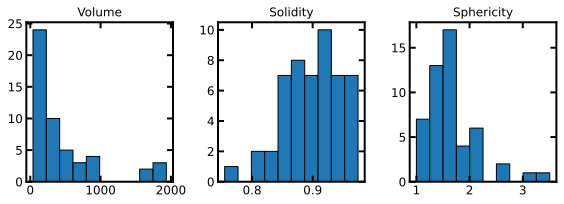

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].hist(df['volume'], edgecolor="k")
ax[1].hist(df['solidity'], edgecolor="k")
ax[2].hist(df['sphericity'], edgecolor="k");
ax[0].set_title("Volume")
ax[1].set_title("Solidity")
ax[2].set_title("Sphericity");

Another useful feature of the Pandas DataFrame is the ability to look at all metrics for a given pore at once, which is done by looking at a single row in all columns:

In [13]:
df.iloc[0]

label                        1.000000
volume                      54.000000
bbox_volume                 66.000000
sphericity                   1.639501
surface_area                42.140678
convex_volume               59.000000
area                        54.000000
area_bbox                   66.000000
area_convex                 59.000000
eccentricity                 0.992984
equivalent_diameter_area     8.291860
euler_number                 1.000000
extent                       0.818182
feret_diameter_max          22.022716
area_filled                 54.000000
axis_major_length           24.417117
axis_minor_length            2.887327
orientation                 -1.538946
perimeter                   43.414214
perimeter_crofton           45.181531
solidity                     0.915254
Name: 0, dtype: float64

## Creating a composite image of region images
Another useful function available in *PoreSpy* is ``prop_to_image``, which can create an image from the various subimages available on each region.

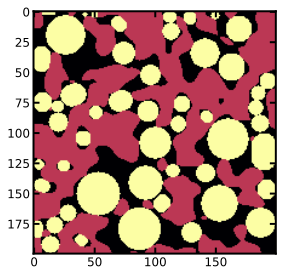

In [14]:
# Create an image of maximally inscribed spheres
sph = ps.metrics.prop_to_image(regionprops=props, shape=im.shape, prop='inscribed_sphere')
fig, ax = plt.subplots()
ax.imshow(sph + 0.5*(~im) , cmap=plt.cm.inferno);

## Creating a colorized image based on region properties
The ``prop_to_image`` function can also accept a scalar property which will result in an image of the regions colorized according to the local value of that property.

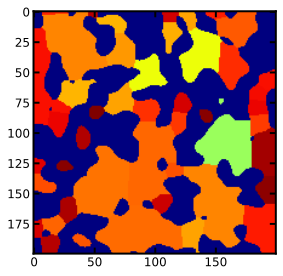

In [15]:
# Create an image colorized by solidity
sph = ps.metrics.prop_to_image(regionprops=props, shape=im.shape, prop='solidity')
fig, ax = plt.subplots()
ax.imshow(sph + 0.5*(~im) , cmap=plt.cm.jet);

An interesting result can be seen where the regions at the edges are darker signifying more *solidity*. This is because the straight edges conform exactly to their convex hulls.